<font size=6>Ocean Data Analysis - Analyzing Sea Surface Temperature w/ Variational Inference</font>

Interesting Research
https://www.nature.com/articles/s41467-018-08066-0

In [1]:
import warnings
warnings.filterwarnings('ignore')

import xarray as xr
!pip install netcdf4
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 

import sklearn 
import sklearn.mixture as mix 
import scipy.stats as stats 

import seaborn as sns
sns.set()

In [37]:
# Buoy in Gulf of Maine
ds = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44005/44005.ncml')
ds = ds.sel(time=slice('2013-04-01','2023-04-27'))
print(ds)

# Get buoy data from NOAA
noaa_df = ds.to_dataframe().reset_index()
print(noaa_df)

<xarray.Dataset>
Dimensions:                  (latitude: 1, longitude: 1, time: 60986)
Coordinates:
  * latitude                 (latitude) float32 43.2
  * longitude                (longitude) float32 -69.13
  * time                     (time) datetime64[ns] 2014-03-19T16:50:00 ... 20...
Data variables: (12/13)
    wind_dir                 (time, latitude, longitude) float64 ...
    wind_spd                 (time, latitude, longitude) float32 ...
    gust                     (time, latitude, longitude) float32 ...
    wave_height              (time, latitude, longitude) float32 ...
    dominant_wpd             (time, latitude, longitude) timedelta64[ns] ...
    average_wpd              (time, latitude, longitude) timedelta64[ns] ...
    ...                       ...
    air_pressure             (time, latitude, longitude) float32 ...
    air_temperature          (time, latitude, longitude) float32 ...
    sea_surface_temperature  (time, latitude, longitude) float32 ...
    dewpt_tempe

In [38]:
# Get sea surface temps
cov = noaa_df[['time','sea_surface_temperature']]
cov = cov.dropna().reset_index().drop(columns=['index'])
cov['sea_surface_temperature'] = cov['sea_surface_temperature'].rolling(14).mean()
cov = cov.dropna()
print(cov)

                     time  sea_surface_temperature
13    2014-03-20 05:50:00                 3.857143
14    2014-03-20 06:50:00                 3.771429
15    2014-03-20 07:50:00                 3.750000
16    2014-03-20 08:50:00                 3.735714
17    2014-03-20 09:50:00                 3.721429
...                   ...                      ...
58713 2023-03-31 18:50:00                 4.778571
58714 2023-03-31 19:50:00                 4.800000
58715 2023-03-31 20:50:00                 4.821429
58716 2023-03-31 21:50:00                 4.835714
58717 2023-03-31 22:50:00                 4.842857

[58705 rows x 2 columns]


In [39]:
# Fit mixture model 
num_components = 5
dpgmm_model = mix.BayesianGaussianMixture(
    n_components=num_components, 
    weight_concentration_prior_type='dirichlet_process',
    n_init=1,
    max_iter=10)
p = dpgmm_model.fit_predict(cov['sea_surface_temperature'].to_numpy().reshape(-1,1))

# Count States
state_counts = np.zeros(num_components)
for M in p:
  state_counts[M] += 1 
print(state_counts)

[11009. 14176.  6215. 18313.  8992.]


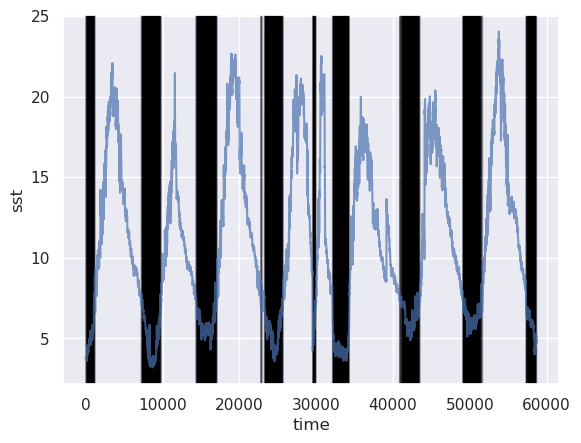

In [40]:
# Plot States
fig2, ax2=plt.subplots()

for M in range(len(p)): 
  if p[M] == p[-1]:
    ax2.axvline(M, color='black', alpha=0.002) 
    
sns.lineplot(data=cov['sea_surface_temperature'].values, ax=ax2, alpha=0.7)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()

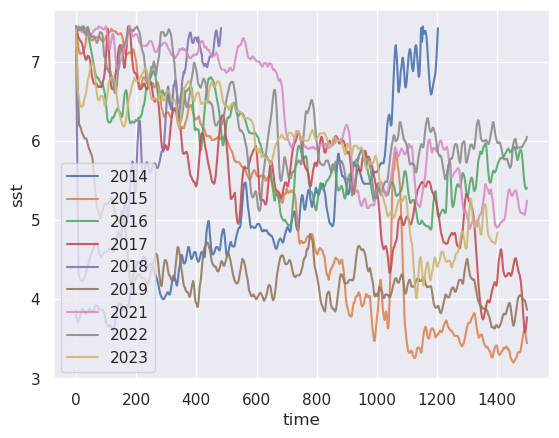

In [44]:
# Plot States Grouped by Year 
fig,ax=plt.subplots()
data={'2014':[],'2015':[],'2016':[],'2017':[],
      '2018':[],
      '2019':[],
      '2020':[],
      '2021':[],
      '2022':[],
      '2023':[]}

for M in range(len(p)): 
  if p[M] == p[-1]:
    yr = str(cov['time'].values[M])[:4]
    data[yr].append(cov['sea_surface_temperature'].values[M])

for cluster in data: 
    #if cluster == '2023':
    sns.lineplot(data=data[cluster][:1500], ax=ax, alpha=0.9, label=cluster)
plt.ylabel('sst')
plt.xlabel('time')
plt.show()


In [ ]:
#%pip install pmdarima
#from pmdarima.arima import auto_arima

# Fit an ARIMA model to the season data
#model = auto_arima(data, seasonal=True, stepwise=True, suppress_warnings=True)
#print(model.summary())

# Predict the next value within the season
#next_value = model.predict(n_periods=1)[-1]